In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()
import matplotlib.pyplot as plt

from timeit import default_timer
from utilities3 import UnitGaussianNormalizer, count_params, LpLoss, MatReader
from pytorch_wavelets import DWT, IDWT # (or import DWT, IDWT)

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# %%

import scipy.io as sio

data_true = sio.loadmat('nagumo_true.mat')
data_prior = sio.loadmat('nagumo_prior.mat')

# %%

u = data_true['u'][:,::2,::2]
u0 = np.repeat(data_true['u0'][:,:,::2], 65, axis = 1)

u_pr = data_prior['u'][:,::2,::2]

print(u.shape)

(10000, 65, 65)


In [3]:
# %%

""" Def: 2d Wavelet layer """

class WaveConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, level, dummy):
        super(WaveConv2d, self).__init__()

        """
        2D Wavelet layer. It does DWT, linear transform, and Inverse dWT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.level = level

        self.wavelet = 'db4'
        self.mode = 'symmetric'
        self.dwt_ = DWT(J=self.level, mode=self.mode, wave=self.wavelet).to(dummy.device)
        self.x_dwt, _ = self.dwt_(dummy) 
        self.modes1 = self.x_dwt.shape[-2]
        self.modes2 = self.x_dwt.shape[-1]

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2))

    # Convolution
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute single tree Discrete Wavelet coefficients using some wavelet
        dwt = DWT(J=self.level, mode=self.mode, wave=self.wavelet).cuda()
        x_ft, x_coeff = dwt(x)

        # Multiply relevant Wavelet modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x_ft.shape[-2], x_ft.shape[-1], device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        # Multiply the finer wavelet coefficients
        x_coeff[-1][:,:,0,:,:] = self.compl_mul2d(x_coeff[-1][:,:,0,:,:].clone(), self.weights2)
        
        # Return to physical space        
        idwt = IDWT(mode=self.mode, wave=self.wavelet).cuda()
        x = idwt((out_ft, x_coeff))
        return x


# %%

""" The forward operation """

class WNO2d(nn.Module):
    def __init__(self, width, level, dummy_data):
        super(WNO2d, self).__init__()

        """
        The WNO network. It contains 4 layers of the Wavelet integral layer.
        1. Lift the input using v(x) = self.fc0 .
        2. 4 layers of the integral operators v(+1) = g(K(.) + W)(v).
            W is defined by self.w_; K is defined by self.conv_.
        3. Project the output of last layer using self.fc1 and self.fc2.
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.width = width
        self.level = level
        self.dummy_data = dummy_data
        self.padding = 1 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.conv1 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.conv2 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.conv3 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 192)
        self.fc2 = nn.Linear(192, 1)

    
        self.fc0_NT = nn.Linear(3, self.width).requires_grad_(False) # input channel is 3: (a(x, y), x, y)

        self.conv0_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.conv1_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.conv2_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.conv3_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.w0_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)
        self.w1_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)
        self.w2_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)
        self.w3_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)

        self.fc1_NT = nn.Linear(self.width, 192).requires_grad_(False)
        self.fc2_NT = nn.Linear(192, 1).requires_grad_(False)
        
    def forward(self, x):
        
        x_Ph= x[:,:,:,1:2]
        x = x[:,:,:,0:1]
        
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)

        x_NT = self.fc0_NT(x)
        x_NT = x_NT.permute(0, 3, 1, 2)
        x_NT = F.pad(x_NT, [0,self.padding,0,self.padding]) # do padding, if required
        
        x1_NT = self.conv0_NT(x_NT)
        x2_NT = self.w0_NT(x_NT)
        x_NT = x1_NT + x2_NT
        x_NT = F.gelu(x_NT)
        
        x1_NT = self.conv1_NT(x_NT)
        x2_NT = self.w1_NT(x_NT)
        x_NT = x1_NT + x2_NT
        x_NT = F.gelu(x_NT)
        
        x1_NT = self.conv2_NT(x_NT)
        x2_NT = self.w2_NT(x_NT)
        x_NT = x1_NT + x2_NT
        x_NT = F.gelu(x_NT)
        
        x1_NT = self.conv3_NT(x_NT)
        x2_NT = self.w3_NT(x_NT)
        x_NT = x1_NT + x2_NT
        
        x_NT = x_NT[..., :-self.padding, :-self.padding] # remove padding, when required
        x_NT = x_NT.permute(0, 2, 3, 1)
        x_NT = self.fc1_NT(x_NT)
        x_NT = F.gelu(x_NT)
        x_NT = self.fc2_NT(x_NT)
        
        
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding]) # padding, if required
        
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)
    
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        
        x = x[..., :-self.padding, :-self.padding] # removing padding, when applicable
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        
        x = x+1*x_NT+x_Ph
        
        return x
    
    def get_grid(self, shape, device):
        # The grid of the solution
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [4]:
# %%

""" Model configurations """

ntrain = 200
ntest = 100

batch_size = 100
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.75

level = 4
width = 64

h = 65
s = 65

# %%

""" Read data """

x_train_1 = torch.tensor(u0[:ntrain], dtype=torch.float32)
x_train_2 = torch.tensor(u_pr[:ntrain], dtype=torch.float32)
y_train = torch.tensor(u[:ntrain], dtype=torch.float32)

x_test_1 = torch.tensor(u0[-ntest:], dtype=torch.float32)
x_test_2 = torch.tensor(u_pr[-ntest:], dtype=torch.float32)
y_test = torch.tensor(u[-ntest:], dtype=torch.float32)

x_normalizer_1 = UnitGaussianNormalizer(x_train_1)
x_train_1 = x_normalizer_1.encode(x_train_1)
x_test_1 = x_normalizer_1.encode(x_test_1)

x_normalizer_2 = UnitGaussianNormalizer(x_train_2)
x_train_2 = x_normalizer_2.encode(x_train_2)
x_test_2 = x_normalizer_2.encode(x_test_2)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train_1 = x_train_1.reshape(ntrain,s,s,1)
x_test_1 = x_test_1.reshape(ntest,s,s,1)

x_train_2 = x_train_2.reshape(ntrain,s,s,1)
x_test_2 = x_test_2.reshape(ntest,s,s,1)

x_train = torch.concat((x_train_1,x_train_2),-1)
x_test = torch.concat((x_test_1,x_test_2),-1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# %%

""" Sample model definition """

model = WNO2d(width, level, x_train[0:1].permute(0,3,1,2)).cuda()
print(count_params(model))

from torchinfo import summary
print(summary(model, input_size=(10, 65, 65, 2)))

6612738
Layer (type:depth-idx)                   Output Shape              Param #
WNO2d                                    [10, 65, 65, 1]           --
├─Linear: 1-1                            [10, 65, 65, 64]          (256)
├─WaveConv2d: 1-2                        [10, 64, 66, 66]          819,200
├─Conv2d: 1-3                            [10, 64, 66, 66]          (4,160)
├─WaveConv2d: 1-4                        [10, 64, 66, 66]          819,200
├─Conv2d: 1-5                            [10, 64, 66, 66]          (4,160)
├─WaveConv2d: 1-6                        [10, 64, 66, 66]          819,200
├─Conv2d: 1-7                            [10, 64, 66, 66]          (4,160)
├─WaveConv2d: 1-8                        [10, 64, 66, 66]          819,200
├─Conv2d: 1-9                            [10, 64, 66, 66]          (4,160)
├─Linear: 1-10                           [10, 65, 65, 192]         (12,480)
├─Linear: 1-11                           [10, 65, 65, 1]           (193)
├─Linear: 1-12           

In [5]:
# snr = 0.25/100

# print(torch.sqrt(torch.mean(x_train_2**2)/snr))

# plt.imshow(x_train_2[0,:,:,0])
# plt.show()

# x_train_2_tst = x_train_2 + torch.sqrt(torch.mean(x_train_2**2)*snr)*torch.randn(x_train_2.shape)

# plt.imshow(x_train_2_tst[0,:,:,0])
# plt.show()

In [6]:
# %%

""" Training and testing """

import pickle

for model_num in range (0,10):

    # x_train_1 = torch.tensor(u0[:ntrain], dtype=torch.float32)
    # x_train_2 = torch.tensor(u_pr[:ntrain], dtype=torch.float32)
    # x_train_2 = x_train_2 + torch.sqrt(torch.mean(x_train_2**2)*snr)*torch.randn(x_train_2.shape)
    # y_train = torch.tensor(u[:ntrain], dtype=torch.float32)
    
    # x_test_1 = torch.tensor(u0[-ntest:], dtype=torch.float32)
    # x_test_2 = torch.tensor(u_pr[-ntest:], dtype=torch.float32)
    # x_test_2 = x_test_2 + torch.sqrt(torch.mean(x_test_2**2)*snr)*torch.randn(x_test_2.shape)
    # y_test = torch.tensor(u[-ntest:], dtype=torch.float32)
    
    # x_normalizer_1 = UnitGaussianNormalizer(x_train_1)
    # x_train_1 = x_normalizer_1.encode(x_train_1)
    # x_test_1 = x_normalizer_1.encode(x_test_1)
    
    # x_normalizer_2 = UnitGaussianNormalizer(x_train_2)
    # x_train_2 = x_normalizer_2.encode(x_train_2)
    # x_test_2 = x_normalizer_2.encode(x_test_2)
    
    # y_normalizer = UnitGaussianNormalizer(y_train)
    # y_train = y_normalizer.encode(y_train)
    
    # x_train_1 = x_train_1.reshape(ntrain,s,s,1)
    # x_test_1 = x_test_1.reshape(ntest,s,s,1)
    
    # x_train_2 = x_train_2.reshape(ntrain,s,s,1)
    # x_test_2 = x_test_2.reshape(ntest,s,s,1)
    
    # x_train = torch.concat((x_train_1,x_train_2),-1)
    # x_test = torch.concat((x_test_1,x_test_2),-1)
    
    # train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    # test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

    y_normalizer.cuda()

    model = WNO2d(width, level, x_train[0:1].permute(0,3,1,2)).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = LpLoss(size_average=False)
    y_normalizer.cuda()
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()
    
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)
            y = y_normalizer.decode(y)
            
            loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
            loss.backward()
            optimizer.step()
            train_l2 += loss.item()
        
        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()
    
                out = model(x).reshape(batch_size, s, s)
                out = y_normalizer.decode(out)
    
                test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()
    
        train_l2/= ntrain
        test_l2 /= ntest
        t2 = default_timer()
        print(model_num, ep, t2-t1, train_l2, test_l2)
        # print(model_num, ep, t2-t1, train_l2)
                
    filename = './RPmodel/PWNO_Noise_'+str(model_num)+'.sav'
    pickle.dump(model, open(filename, 'wb'))

0 0 1.1414707880467176 0.0345672345161438 0.03224735736846924
0 1 1.1173059791326523 0.027699694633483887 0.03010003089904785
0 2 1.134509190917015 0.02787523627281189 0.02509865999221802
0 3 1.1198171805590391 0.022376501560211183 0.024806499481201172
0 4 1.1186490766704082 0.024875530004501344 0.022507572174072267
0 5 1.1304303854703903 0.021305408477783203 0.023444314002990723
0 6 1.1157501842826605 0.023347272872924804 0.024086885452270508
0 7 1.1153841875493526 0.021848368644714355 0.020707433223724366
0 8 1.1159651018679142 0.020507034063339234 0.021887383460998534
0 9 1.1144261248409748 0.02101653814315796 0.0201878023147583
0 10 1.1154550090432167 0.019880372285842895 0.021363286972045897
0 11 1.1140300557017326 0.02029921591281891 0.01960599660873413
0 12 1.132770523428917 0.019117069840431215 0.019899145364761353
0 13 1.128516597673297 0.019344613552093506 0.018704142570495606
0 14 1.1160452328622341 0.018152152299880982 0.018920379877090453
0 15 1.1151978801935911 0.01835738

In [5]:
# %%

import pickle
myloss = LpLoss(size_average=False)

""" Prediction """


ntest = 8000
bs = 100
x_test_1 = torch.tensor(u0[-ntest:], dtype=torch.float32)
x_test_2 = torch.tensor(u_pr[-ntest:], dtype=torch.float32)
# x_test_2 = x_test_2 + torch.sqrt(torch.mean(x_test_2**2)*snr)*torch.randn(x_test_2.shape)
y_test = torch.tensor(u[-ntest:], dtype=torch.float32)

x_test_1 = x_normalizer_1.encode(x_test_1)
x_test_2 = x_normalizer_2.encode(x_test_2)

x_test_1 = x_test_1.reshape(ntest,s,s,1)
x_test_2 = x_test_2.reshape(ntest,s,s,1)

x_test = torch.concat((x_test_1,x_test_2),-1)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

""" Prediction """

y_normalizer.cuda()
pred = torch.zeros([10, y_test.shape[0], y_test.shape[1], y_test.shape[2]])
# myloss = LpLoss(size_average=False)

for model_num in range (0,10):

    print(model_num)
    filename = './RPmodel/PWNO_Noise_'+str(model_num)+'.sav' ## TRIAL 103
    loaded_model = pickle.load(open(filename, 'rb'))

    index = 0
    test_e = torch.zeros(y_test.shape[0])
    
    with torch.no_grad():
        for x, y in test_loader:
            t1 = default_timer()
            test_l2 = 0
            x, y = x.cuda(), y.cuda()
    
            out = loaded_model(x).reshape(bs,s, s)
            out = y_normalizer.decode(out)
            pred[model_num,index*bs:(index+1)*bs,:,:] = out
    
            test_l2 = myloss(out.reshape(100, s, s), y.reshape(100, s, s)).item()
            test_e[index] = test_l2
            
            print(index, test_l2)
            
            t2 = default_timer()
            print(model_num, index, t2-t1)
            
            index = index + 1
            
        print('Mean Testing Error:', 100*torch.mean(test_e).numpy(), '%')

0


/home/souvik/anaconda3/envs/SG_pytorch/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


0 0.376456618309021
0 0 0.37349139200523496
1 0.34536388516426086
0 1 0.3216561379376799
2 0.3361058831214905
0 2 0.3207702930085361
3 0.32914307713508606
0 3 0.3209435229655355
4 0.3451637029647827
0 4 0.32055271114222705
5 0.34295642375946045
0 5 0.32037881086580455
6 0.3245766758918762
0 6 0.32038664701394737
7 0.33869606256484985
0 7 0.32049824902787805
8 0.32149556279182434
0 8 0.32047771802172065
9 0.34651997685432434
0 9 0.3208163201343268
10 0.32703346014022827
0 10 0.3205792340449989
11 0.34913575649261475
0 11 0.320419933879748
12 0.33879220485687256
0 12 0.32113877683877945
13 0.3127335011959076
0 13 0.3206803819630295
14 0.34506145119667053
0 14 0.32083243294619024
15 0.326151043176651
0 15 0.32058387203142047
16 0.34797781705856323
0 16 0.320409158943221
17 0.3285605311393738
0 17 0.32056979392655194
18 0.3251885175704956
0 18 0.3203923818655312
19 0.3486998677253723
0 19 0.3212931619491428
20 0.3208651542663574
0 20 0.3204368408769369
21 0.30655980110168457
0 21 0.3202605

49.077744483947754
0.0015359622371607666


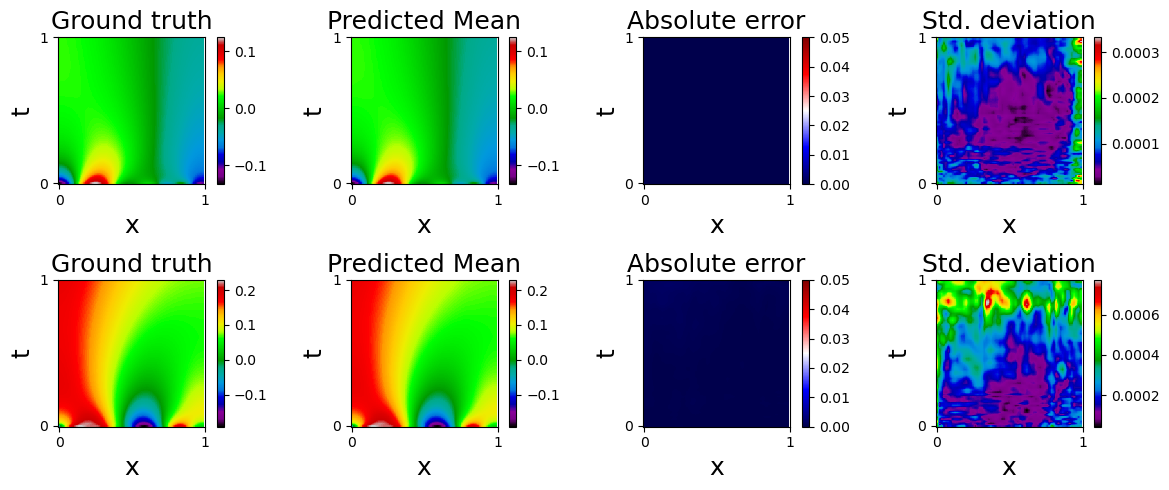

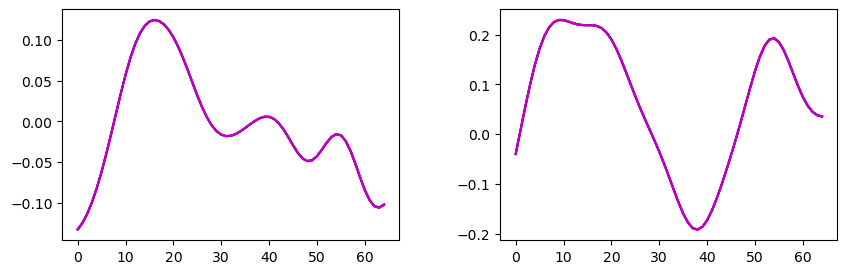

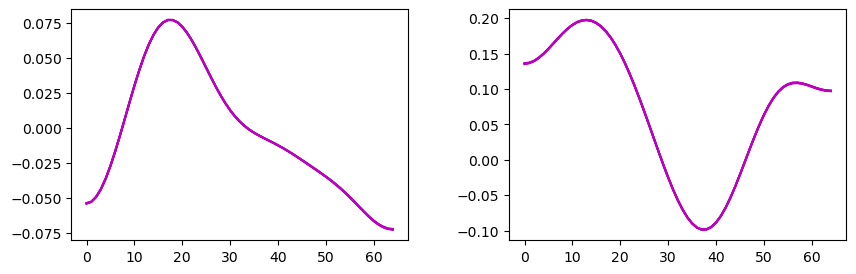

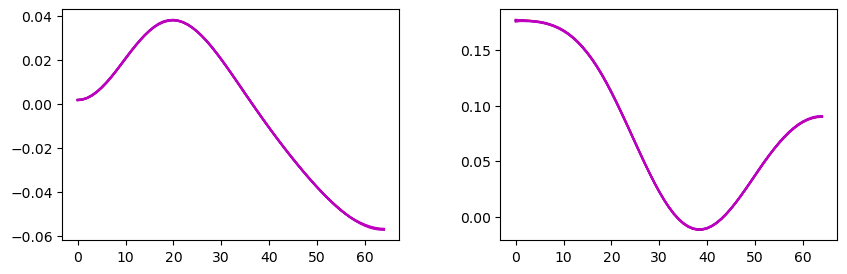

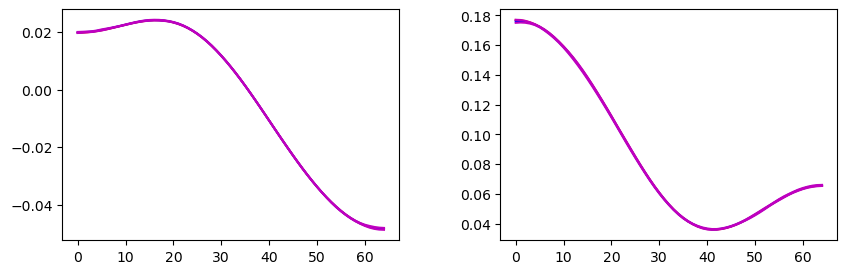

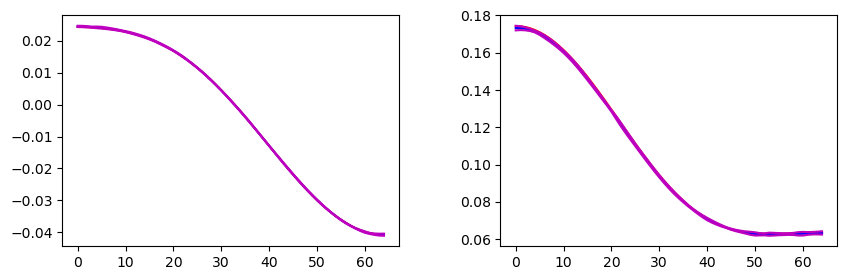

In [9]:
# %%

m = np.mean(pred.numpy(),0)
std = np.std(pred.numpy(),0)

plt.figure(constrained_layout=False, figsize = (12, 5))
plt.subplots_adjust(hspace=0.75)
index = 1
for value in range(y_test.shape[0]):
    if value % 6000 == 1:

        plt.subplot(2,4, index)
        plt.imshow(y_test[value,:,:], origin='lower', cmap='nipy_spectral',
                   vmin = np.min(y_test[value,:,:].numpy()), vmax = np.max(y_test[value,:,:].numpy()))
        plt.colorbar()
        plt.title('Ground truth',fontsize = 18)
        plt.xticks([0,65],[0,1])
        plt.yticks([0,65],[0,1])
        plt.xlabel('x',fontsize = 18)
        plt.ylabel('t',fontsize = 18)
        index = index+1
                
        plt.subplot(2,4, index)
        plt.imshow(m[value,:,:], origin='lower', cmap='nipy_spectral',
                   vmin = np.min(y_test[value,:,:].numpy()), vmax = np.max(y_test[value,:,:].numpy()))
        plt.colorbar()
        plt.title('Predicted Mean',fontsize = 18)
        plt.xticks([0,65],[0,1])
        plt.yticks([0,65],[0,1])
        plt.xlabel('x',fontsize = 18)
        plt.ylabel('t',fontsize = 18)
        index = index+1
        
        plt.subplot(2,4, index)
        plt.imshow(torch.abs(y_test[value,:,:] - m[value,:,:]), origin='lower',
                   vmin = 0, vmax = 0.05, cmap='seismic')
        plt.colorbar()
        plt.title('Absolute error',fontsize = 18)
        plt.xticks([0,65],[0,1])
        plt.yticks([0,65],[0,1])
        plt.xlabel('x',fontsize = 18)
        plt.ylabel('t',fontsize = 18)
        index = index+1
        
        plt.subplot(2,4, index)
        plt.imshow(std[value,:,:], origin='lower', cmap='nipy_spectral')
        plt.colorbar()
        plt.title('Std. deviation',fontsize = 18)
        plt.xticks([0,65],[0,1])
        plt.yticks([0,65],[0,1])
        plt.xlabel('x',fontsize = 18)
        plt.ylabel('t',fontsize = 18)
        
        index = index + 1

plt.tight_layout()
plt.savefig('with_prior.pdf')
print((100*myloss(y_test, torch.tensor(m)).item())/40)
print(100*torch.mean((y_test-torch.tensor(m))**2).item()/torch.mean((y_test**2)).item())

# %%

for marker in ([1-1,5-1,15-1,30-1,50-1]):
    plt.figure(constrained_layout=False, figsize = (10, 3))
    plt.subplots_adjust(wspace=0.3)
    index = 0
    for value in range(y_test.shape[0]):
        if value % 6000 == 1:
            plt.subplot(1,2, index+1)
            plt.plot(y_test[value,marker,:],'r')
            plt.plot(m[value,marker,:],'b')
            plt.plot(m[value,marker,:]+1.96*std[value,marker,:],'m')
            plt.plot(m[value,marker,:]-1.96*std[value,marker,:],'m')

            index = index + 1

In [7]:
100*torch.mean((y_test-m)**2)/torch.mean((y_test)**2)

tensor(0.0015)

In [8]:
errsq = np.mean((m.reshape(-1)-y_test.numpy().reshape(-1))**2)
trsq = np.mean((y_test.numpy().reshape(-1))**2)

print(errsq*100/trsq)

0.0015359655878557194
